In [1]:
import os
os.environ['PYTHONPATH']='/home/alxogm/notebooks/mytutorial/psf_lensing/GalSim/:'+os.environ['PYTHONPATH']
os.environ['PATH']='/home/alxogm/notebooks/mytutorial/psf_lensing/GalSim/:'+os.environ['PATH']

In [2]:
# standard python imports
import numpy as np
import os
import scipy
import astropy.io.fits as pyfits
import scipy.ndimage
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable

# lenstronomy utility functions
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel


import galsim
print(galsim.__file__)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/galsim/__init__.py


# Lensed source images generation using galsim profiles

In this notebook I generate images of lensed sources to then be injected in DC2/Rubin images. For now the images will be saved in a file, but ultimately, I will streamline the image generation process

In [7]:
# Load galsim catalog
data_dir ="/home/alxogm/notebooks/mytutorial/psf_lensing/COSMOS_23.5_training_sample/"
print(data_dir)
cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5.fits')

/home/alxogm/notebooks/mytutorial/psf_lensing/COSMOS_23.5_training_sample/


In [8]:
#Galsim galaxy object

def draw_source(i, pix = 0.03, shape = [150,150], shift = [0,0], smooth = 0.06):
    
    gal = cat.makeGalaxy(i, gal_type = "real", noise_pad_size= 0).withFlux(1)
    if smooth > 0:
        gal = galsim.Convolve(gal, galsim.Gaussian(sigma=smooth))

    gal = gal.shift(dx=shift[0], dy=shift[1])
    
    gal_image = gal.drawImage(nx=shape[0],
                              ny=shape[1],
                              use_true_center = True,
                              method='real_space',
                              scale=pix,
                              dtype=np.float64).array
    return gal_image

In [27]:
image = draw_source(np.int(np.random.rand()*len(cat)))#np.int(np.random.rand()*len(cat)))

/tmp/ipykernel_15058/1894924171.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = draw_source(np.int(np.random.rand()*len(cat)))#np.int(np.random.rand()*len(cat)))


In [28]:
# now we come to the Shapelet decomposition
# we turn the image in a single 1d array
image_1d = util.image2array(image)  # map 2d image in 1d data array

# we define the shapelet basis set we want the image to decompose in
n_max = 150  # choice of number of shapelet basis functions, 150 is a high resolution number, but takes long
beta = 10  # shapelet scale parameter (in units of resized pixels)

x, y = util.make_grid(numPix=n_max, deltapix=1)

# import the ShapeletSet class
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar
shapeletSet = ShapeletSet()

# decompose image and return the shapelet coefficients
coeff_ngc = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0) 

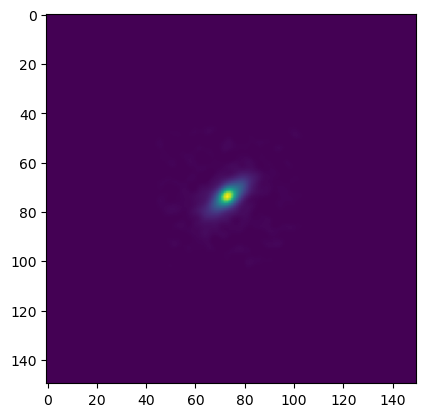

In [29]:
# reconstruct NGC1300 with the shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, coeff_ngc, n_max, beta, center_x=0, center_y=0)
# turn 1d array back into 2d image
image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image
image_reconstructed_2d[image_reconstructed_2d<0] = 0

plt.imshow(image_reconstructed_2d)
plt.show()

In [30]:
# define data specifics
background_rms = 10.  #  background noise per pixel
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 64  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
high_res_factor = 5
subgrid_res = high_res_factor  # we set the subgrid resolution to the high resolution image that we will show, so the same numerics will be applied.
fwhm = 0.1 # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'


# define lens model
lens_model_list = ['SPEP', 'SHEAR']
kwargs_spemd = {'theta_E': 0.5, 'gamma': 2., 'center_x':0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_shear = {'gamma1': 0.0, 'gamma2': 0.0}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# define center of the source (effectively the center of the Shapelet basis)
source_x = 0.2
source_y = 0.

# define the source size (effectively the Shapelet scale parameter)
beta_model = 0.06
# use the shapelet coefficients decomposed from NGC1300
coeff = coeff_ngc / deltaPix**2
kwargs_shapelet = {'n_max': n_max, 'beta': beta_model, 'amp': coeff, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SHAPELETS']
kwargs_source = [kwargs_shapelet]

# for this example, we do not include deflector light
lens_light_model_list = ['NONE']
kwargs_lens_light = [{}]

lensModel = LensModel(lens_model_list)
sourceLightModel = LightModel(source_model_list)


In [31]:


# here we perform the computation with the settings choosen above.
# We set up the different Data and PSF classes to perform and return the output at various stages of the computation
# final data configuration
kwargs_data_real = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_real = ImageData(**kwargs_data_real)
# high resolution data configuration
kwargs_data_high_res = sim_util.data_configure_simple(numPix*high_res_factor, deltaPix/high_res_factor, exp_time, background_rms)
data_high_res = ImageData(**kwargs_data_high_res)
# final psf configuration
#kwargs_psf = {'psf_type'}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, truncate=10)
psf = PSF(psf_type=psf_type, fwhm=fwhm, truncation=5)
psf_high_res = psf
# psf configuration performed on the high resolution gird (effectively the same convolution as the final psf)
#kwargs_psf_high_res = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=31, deltaPix=deltaPix/high_res_factor, truncate=6, kernel=None)
#psf_high_res = PSF(**kwargs_psf_high_res)
# no psf convolution
#kwargs_psf_no = sim_util.psf_configure_simple(psf_type='NONE')
psf_no = PSF(psf_type='NONE')
# the numerics applied on the final data output to perform the identical computation as the high resolution gird
kwargs_numerics = {'supersampling_factor': subgrid_res, 'supersampling_convolution': True}

# and here we perform the computations

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_high_res_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel_ = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, source_model_class=sourceLightModel)
image_high_res_nolens_large = imageModel_.image(kwargs_lens=None, kwargs_source=kwargs_source, kwargs_lens_light=None, kwargs_ps=None)




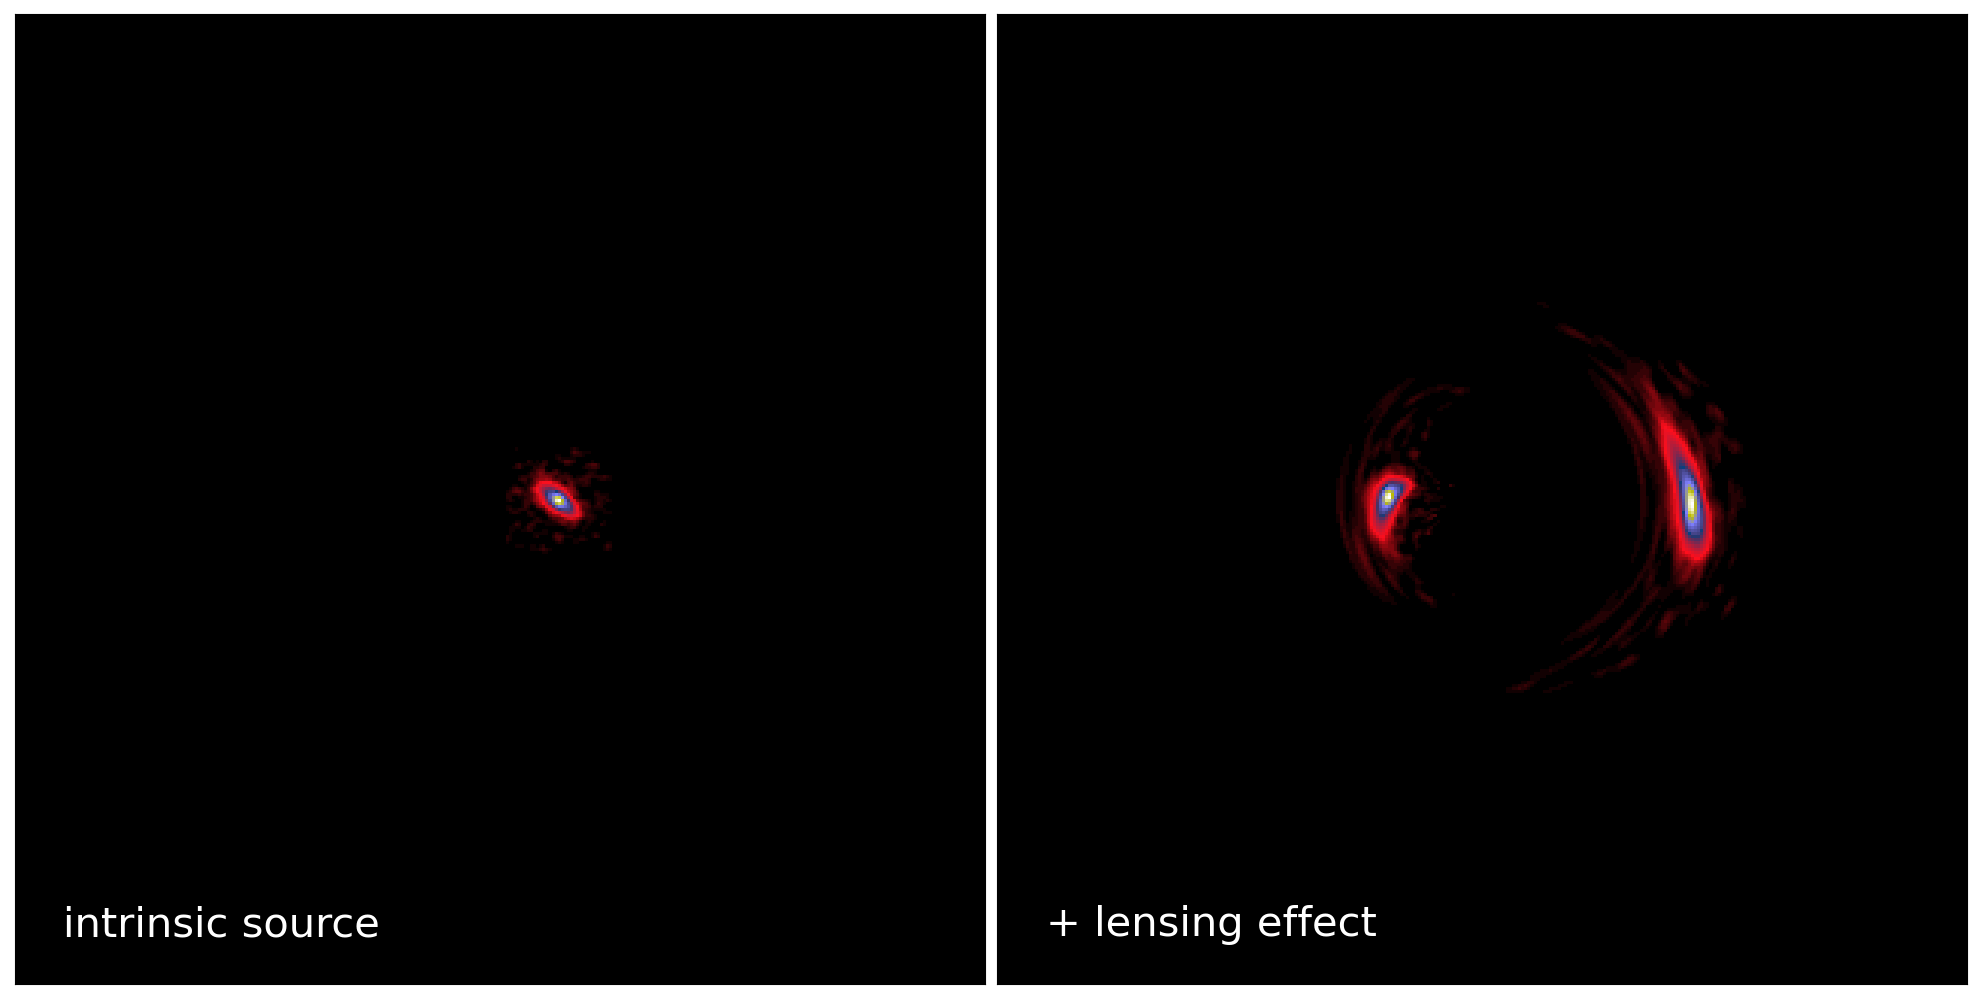

In [32]:
# the result is illustrated here

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = 0
v_max = 2

image_high_res_nolens_large[image_high_res_nolens_large<0]=0
image_high_res_lensed[image_high_res_lensed<0]=0

f, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

ax = axes[0]
im = ax.matshow((image_high_res_nolens_large), origin='lower', extent=[0, 1, 0, 1], cmap = "gist_stern")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
    
ax = axes[1]
im = ax.matshow((image_high_res_lensed), origin='lower', extent=[0, 1, 0, 1], cmap = "gist_stern")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

i = 0
ax = axes[0]
x_pos, y_pos = 0.05, 0.05
fontsize_description = 30
ax.text(x_pos, y_pos, "intrinsic source", color="w", fontsize=fontsize_description)
ax = axes[1]
ax.text(x_pos, y_pos, "+ lensing effect", color="w", fontsize=fontsize_description)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/simAPI.pdf', format='pdf')
plt.show()


In [33]:
# Interpolate hr image
gal_hr = galsim.InterpolatedImage(galsim.Image(image_high_res_lensed), scale = 0.03)

# Rotate hr galaxy to lr frame
#rot_gal = gal_hr.rotate(galsim.Angle(angle, galsim.radians))

# Downsamples to low resolution
interp_gal = gal_hr.drawImage(nx=150,ny=150, scale=0.06, method='no_pixel',)
img = interp_gal.array

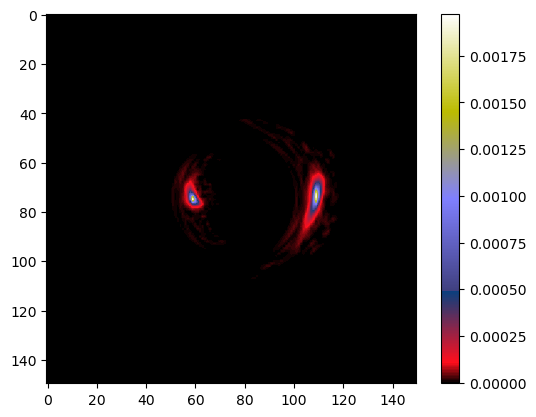

In [34]:
plt.imshow(img, cmap = "gist_stern")
plt.colorbar()
plt.show()

In [35]:
import pickle

file = open( "lensed_source_2", "wb" )
pickle.dump( image_high_res_lensed, file)
file.close()